In [1]:
# To generate maps in flat-sky approximation we need NaMaster (pymaster)
# To install pymaster -> conda install namaster -c conda-forge
import pymaster as nmt
import healpy
# If you prefer to work on spherical geometry you can use HEALPix/healpy -> conda install healpy -c conda-forge or pip install healpy
#Important! If you are using this in a notebook, import pymaster *before* any matplotlib/numpy to avoid OpenMP conflicts

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [3]:
#We are going to generate flatmaps using the Flatmap class
import flatmaps as fm
from astropy.wcs import WCS

In [4]:
l, clTTa, clEEa, clTEa, clPPa, clPTa = np.loadtxt("planck_2018_cl/base_plikHM_TTTEEE_lowl_lowE_lensing_scalCls.dat", unpack=True)

In [5]:
# Generate an artificial power-spectrum (you can use a "realistic" power-spectrum from CAMB or CLASS)
#ells_input = np.arange(1,10000) # We generate 10,000 multipoles
clTT = clTTa /((l*(l+1)/(2*np.pi))) # Simple power-law power-spectrum
clEE = clEEa /((l*(l+1)/(2*np.pi))) # Simple power-law power-spectrum
clTE = clTEa /((l*(l+1)/(2*np.pi))) # Simple power-law power-spectrum
clPP = clPPa / (l**4 * (2.726 * 1e6)**2) # Simple power-law power-spectrum 
clPT = clPTa / (l**4) # Simple power-law power-spectrum
cl_input = [clTT, clEE, clTE, clPP, clPT]

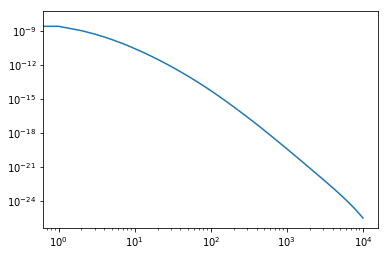

In [6]:
plt.plot(clPP)
plt.xscale("log")
plt.yscale("log")

In [17]:
# Create the empty map object with the resolution that we want
pixels = 192.
reso = 5/pixels 
side = 5 # 5 degree side
# Generate the WCS (world coordinate system) for the flatmap
w = WCS(naxis=2)
nx = int(side/reso) #Number of pixels in the x axis
ny = int(side/reso) #Number of pixels in the y axis
w.wcs.crpix = [nx/2, ny/2] # Center pixel X, Y
w.wcs.cdelt = np.array([-reso, reso])
w.wcs.crval = [0, 0] # Center coordinates RA, DEC at 0,0
w.wcs.ctype = ["RA---COE", "DEC--COE"] # Gnomonic projection
fmi = fm.FlatMapInfo(w, nx=nx, ny=ny, lx=side, ly=side) # This is the map object that will be used to generate the fake CMB maps

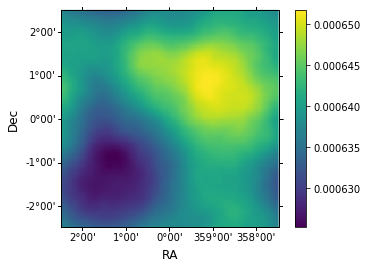

In [18]:
w.wcs.ctype = ["RA---AIR", "DEC--AIR"] # Airy projection
fmi = fm.FlatMapInfo(w, nx=nx, ny=ny, lx=side, ly=side)

phi_map = nmt.synfast_flat(int(fmi.nx),int(fmi.ny),fmi.lx_rad,fmi.ly_rad, [clPP],[0], seed = 0)

fmi.view_map(phi_map[0].flatten()) 

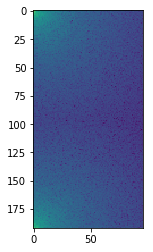

In [19]:
phi_map_fft = np.fft.rfft2(phi_map[0])

plt.imshow(abs(phi_map_fft), norm=matplotlib.colors.LogNorm())

np.save("phi_map_fft", phi_map_fft)

In [20]:
phi_map_ql = np.load("phi_map_ql_structure.npy")

In [51]:
data = phi_map_ql/phi_map[0]

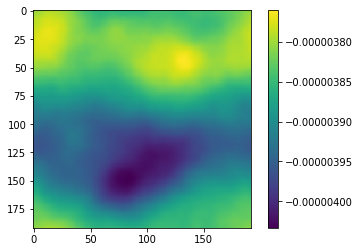

In [53]:
plt.imshow(1/data)
plt.colorbar()

In [54]:
phi_map_fft_ql = np.load("phi_map_fft_ql_structure.npy")

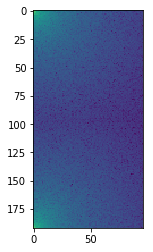

In [61]:
plt.imshow(abs(phi_map_fft_ql), norm=matplotlib.colors.LogNorm())

In [25]:
phi_map_ql

array([[-167.31627017, -167.31942932, -167.30886916, ..., -167.30020886,
        -167.30174114, -167.30695462],
       [-167.35855308, -167.35385637, -167.33926052, ..., -167.35377131,
        -167.34898473, -167.35169421],
       [-167.40453029, -167.39054819, -167.37540979, ..., -167.40909235,
        -167.40119235, -167.40375174],
       ...,
       [-167.23056218, -167.23358287, -167.22232539, ..., -167.18827203,
        -167.20296713, -167.21760818],
       [-167.26100152, -167.26142952, -167.25265617, ..., -167.21750684,
        -167.22889051, -167.24716837],
       [-167.28549832, -167.28731522, -167.2802925 , ..., -167.25401344,
        -167.26205685, -167.2750015 ]])

In [10]:
num_maps = 11200
i=0
all_maps = np.zeros([num_maps,int(pixels),int(pixels)])
while i < num_maps:
    map_gen = nmt.synfast_flat(int(fmi.nx),int(fmi.ny),fmi.lx_rad,fmi.ly_rad, [clPP],[0], seed = i)
    all_maps[i] = map_gen
    if np.mod(i,100) == 0:
        print i,
    i+=1

0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100 4200 4300 4400 4500 4600 4700 4800 4900 5000 5100 5200 5300 5400 5500 5600 5700 5800 5900 6000 6100 6200 6300 6400 6500 6600 6700 6800 6900 7000 7100 7200 7300 7400 7500 7600 7700 7800 7900 8000 8100 8200 8300 8400 8500 8600 8700 8800 8900 9000 9100 9200 9300 9400 9500 9600 9700 9800 9900 10000 10100 10200 10300 10400 10500 10600 10700 10800 10900 11000 11100


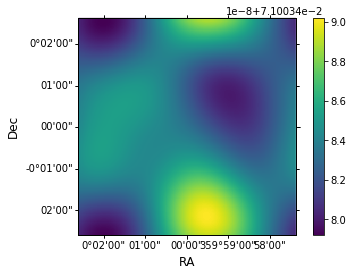

In [11]:
fmi.view_map(all_maps[502].flatten())

In [12]:
np.save("./all_maps_kappa", all_maps)

In [13]:
np.shape(all_maps)

(11200, 192, 192)